<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

### Introducción

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcomisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente.

Por otro lado, se encuentra el problema de las **islas de calor urbanas**, las cuales pueden ser definidas como zonas donde las estructuras como edificios y calles, entre otras estructuras, reemiten el calor proveniente del sol en mayor cantidad que los paisajes naturales. De esta manera, en zonas urbanas donde, por ejemplo, hay muy baja vegetación, se convierten en focos o "islas" de calor $^2$.

Si bien estos dos temas pueden parecer disconexos, diversos estudios que afirman que existe una correlación entre criminalidad y calor $^3$. Como menciona Robin Cooper, el incremento de temperatura causado por las islas de calor urbanas, generado por estructuras de asfalto y concreto y la limitación de espacios verdes, pueden contribuir al aumento de la violencia en verano dentro de las ciudades $^4$. A partir de esta idea, es de nuestro interés investigar si hay alguna correlación particular entre los crímenes con enfoque de género y las islas de calor.


### Objetivos generales y específicos 
A rasgos generales, se busca determinar si hay alguna correlación entre las islas de calor urbana y la cantidad de crímenes cometidos contra mujeres en Nueva York. Incluímos también un pequeño análisis de la violencia de género a través del año para ver si en meses más calurosos se presencia un alza en los casos. Como pasos intermedios, se calculará la autocorrelación espacial de los crímenes, lo que nos permitirá visualizar si hay alguna distribución particular en su ocurrencia.


### Descripción de los datos utilizados
Para la realización de los objetivos, se decidió trabajar con datos de Nueva York, pues esta ciudad cuenta con una estructura bien pavimentada, y abundancia de edificios. Así mismo, la policía de la ciudad cuenta con una gran cantidad de datasets de acceso público. Se descargó la data criminal histórica de la ciudad, la cual contenía crímenes desde el año 1973 hasta mayo del 2023. Este dataset contaba con 8 millones de filas, la información de los crímenes está georeferenciada. Cabe notar que por las dimensiones masivas del dataset, realizamos el trabajo de filtrado previamente a subirlo. El preprocesamiento se encuentra en el archivo ***preprocess_nypdcrimes.ipynb***. Dado el enfoque de género de nuestro trabajo, posteriormente se filtró este dataset dejando únicamente aquellos crímenes que caigan bajo la categoría de violencia de género. Estos corresponden a violación, acoso, secuestro y crímenes sexuales.

También descargamos la información sobre las manzanas de la ciudad en forma vectorial, la cual se encuentra almacenada en ***census/nyc_census_tracts.csv***. De esta manera fue posible acceder a los polígonos de cada manzana censal. Otra columna fundamental el GEOID, la cual es el identificador de la comuna.

Para la información demográfica consultamos la información censal de EEUU actualizada al 2020 y que está almacenada en **squares/nyct2020.shp**. Se realizó un merge con la capa vectorial de las manzanas de Nueva York para tener toda la información incluída en las manzanas. Esto fue posible gracias a que las manzanas tienen una columna fundamental el GEOID, la cual se condice con CensusTracts de la data censal. De esta manera, pudimos asignar información relevante como población total y cantidad de mujeres al geodataframe.

Contamos también con las imágenes entregadas por LANDSAT 9, el cual contiene una banda térmica infrarroja (TIRS), con la que podemos acceder a la temperatura superficial da ciudad. Estas imágenes tienen una resolución de 30 metros y una frecuencia actualización o resolución espacial de 8 días $^5$ considerando para todo el trabajo 7 imágenes y trabajando con el promedio.


### Consideraciones
Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset: violación, acoso, secuestro, crímenes sexuales y homicidio. Los datos corresponden a los crímenes ocurridos en el año 2022 en la ciudad de Nueva York.

Sobre las imágenes obtenidas de landast 9, se consideró las islas de calor com un fenómeno constante a través del año. Se hace esta consideración puesto que las islas de calor se generan por la naturaleza de su entorno (poca vegetación, grtan cantidad de hormigón y asfalto, etc.).

Para efectos de nuestro análsis, consideramos una isla de calor cualquier zona cuya temperatura media sea mayor a 48ºC.

**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

2. United States Enviromental Protection Energy (2022, September 2). Learn About Heat Islands. Retrieved July 5, 2023, from https://www.epa.gov/heatislands/learn-about-heat-islands

3. Sommer, A.J., Lee, M. & Bind, MA.C. Correction: Comparing apples to apples: an environmental criminology analysis of the effects of heat and rain on violent crimes in Boston. Palgrave Commun 5, 102 (2019). https://doi.org/10.1057/s41599-019-0313-y

4. Cooper, R. (2019, July 30). The Impacts of Extreme Heat on Mental Health. Psychiatric Times. Retrieved July 5, 2023, from https://www.psychiatrictimes.com/view/impacts-extreme-heat-mental-health

5. Nasa (n.d.). Landsat 9 carries two science instruments. Landsat Science. Retrieved July 5, 2023, from https://landsat.gsfc.nasa.gov/satellites/landsat-9/landsat-9-overview/

### 1. Importaciones y lecturas

In [38]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns
import libpysal as ps
from libpysal import weights
import esda
from time import time
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import animation
import imageio
import IPython.display as display

In [39]:
# ee.Authenticate()
ee.Initialize()

In [40]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [41]:
big_crimes['OFNS_DESC'].unique()

array(['RAPE', 'HARRASSMENT 2', 'SEX CRIMES',
       'KIDNAPPING & RELATED OFFENSES', 'KIDNAPPING', 'FELONY SEX CRIMES'],
      dtype=object)

In [42]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


Definimos la región que posteriormente usaremos para clipear las imágenes

<Axes: >

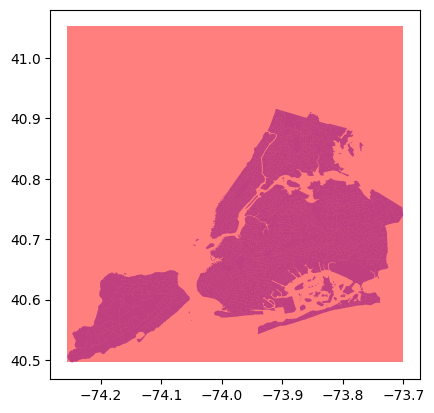

In [9]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [10]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [11]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

Conseguimos las imágenes y calculamos la media de temperaturas en cada pixel

In [12]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))
images

7


['LANDSAT/LC09/C02/T1_L2/LC09_013031_20220611',
 'LANDSAT/LC09/C02/T1_L2/LC09_013032_20220611',
 'LANDSAT/LC09/C02/T1_L2/LC09_014031_20220618',
 'LANDSAT/LC09/C02/T1_L2/LC09_014031_20220704',
 'LANDSAT/LC09/C02/T1_L2/LC09_014032_20220602',
 'LANDSAT/LC09/C02/T1_L2/LC09_014032_20220618',
 'LANDSAT/LC09/C02/T1_L2/LC09_014032_20220704']

Se muestra un histograma que muestra como distribuye la temperatura en la ciudad. Se realiza esta parte para comprender mejor como funciona trabajar con capas de temperatura. Luego se realizará un procedimiento similar para crear un timelapse de las temperaturas en Nueva york a través de los meses de 2022.

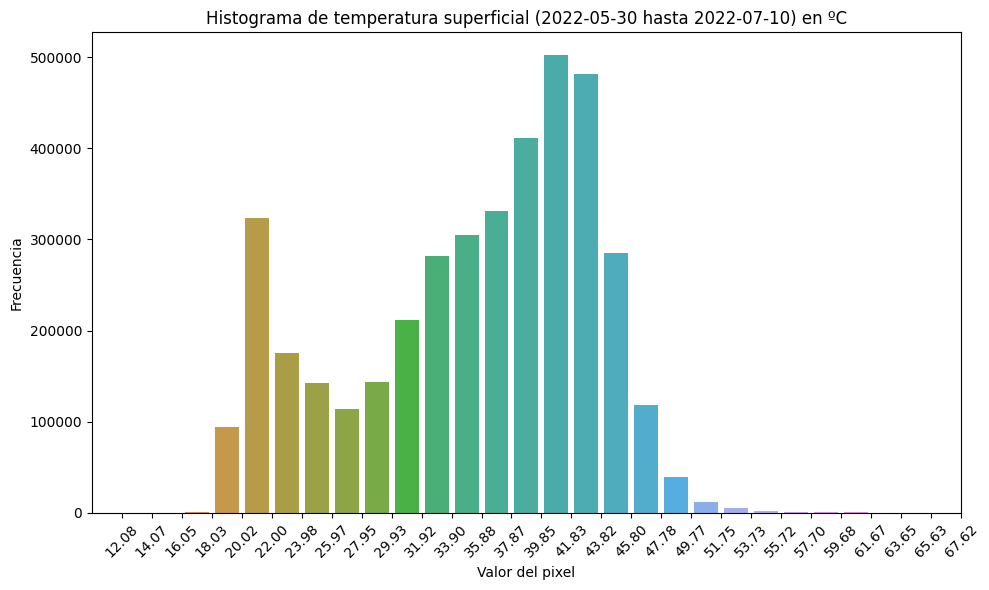

In [13]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

Este histograma corresponden a las temperaturas del siguiente mapa:

In [14]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

Notar que las zonas en negro, como se define abajo, son las zonas con temperaturas mayores a 48ºC. Esto es lo que consideraremos como isla de calor para los fines de nuestro trabajo.

In [15]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [16]:
layer_list = []
for i in range(1, 6):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2023-0{i}-28', f'2023-0{i+2}-14').map(cloudMask)
    filtered= col.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered.map(applyScaleFactors)
    mean_ST = landST.mean()
    clip_mean_ST = mean_ST.clip(aoi)
    layer_list.append(clip_mean_ST)

    values_ST = clip_mean_ST.select('ST_B10')
    temperature_mean = values_ST.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=clip_mean_ST.geometry(),
        scale=values_ST.projection().nominalScale())
    
    mean_val = temperature_mean.get('ST_B10').getInfo()
    print(mean_val)

11.414654734999997
11.587017388289487
16.64287611657896
33.46369139428575
33.46369139428575


A continuación se muestran las imágenes térmicas para distintos meses del año. Se elige ese rango de tiempo debido a que rangos menores generan imágenes vacías.

In [17]:
heat_params = {'min': 0,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [18]:
def get_pixel_values(image):
    values = image.select('ST_B10').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=image.projection().nominalScale())
    mean_val = values.get('ST_B10').getInfo()
    return mean_val

11.414654734999997
11.587017388289487
16.64287611657896
33.46369139428575
33.46369139428575


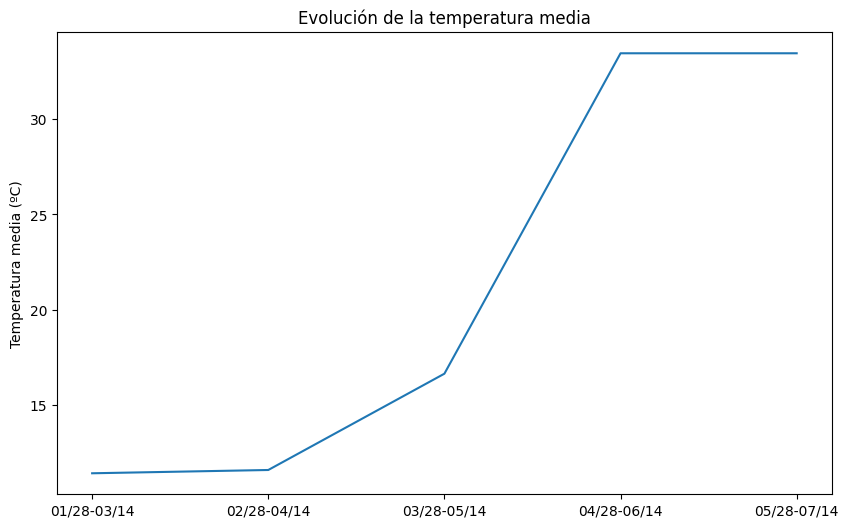

In [19]:
frames = []
for layer in layer_list:
    mean_val = get_pixel_values(layer)
    print(mean_val)
    frames.append(mean_val)

# Plot the evolution of images
plt.figure(figsize=(10, 6))
plt.plot([f'0{i}/28-0{i+2}/14' for i in range(1,len(frames) + 1)], frames)
plt.xlabel('')
plt.ylabel('Temperatura media (ºC)')
plt.title('Evolución de la temperatura media')
plt.show()

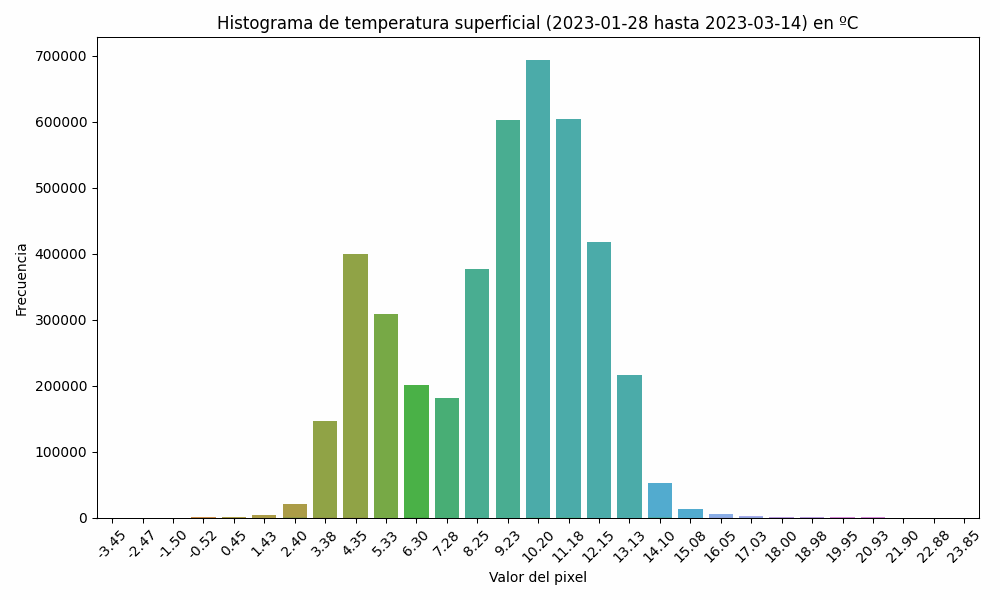

In [36]:
# Puede no ejecutar este codigo y solamente ver el GIF que está en imágenes. Es equivalente.

def get_histogram(image):
    values_ST = image.select('ST_B10')
    histogram_ST = values_ST.reduceRegion(
        reducer=ee.Reducer.histogram(30),
        geometry=aoi,
        scale=30
    )
    histogram_info = histogram_ST.get('ST_B10').getInfo()
    histogram_values = histogram_info['histogram']
    bucket_means = np.array(histogram_info['bucketMeans'])  # Convert to NumPy array

    bin_edges = bucket_means - (bucket_means[1] - bucket_means[0]) / 2
    bin_edges = np.append(bin_edges, bin_edges[-1] + (bucket_means[1] - bucket_means[0]))

    histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

    return histogram_df

histogram_frames = []

for i in range(5):
    histogram_df = get_histogram(layer_list[i])
    histogram_frames.append(histogram_df)

max_bins = max([len(df['bin_edges']) for df in histogram_frames])

for histogram_df in histogram_frames:
    # Interpolate or truncate bin edges and histogram values
    bin_edges = np.linspace(histogram_df['bin_edges'].min(), histogram_df['bin_edges'].max(), len(histogram_df))
    histogram_values = np.interp(bin_edges, histogram_df['bin_edges'], histogram_df['histogram_values'])
    
    histogram_df['bin_edges'] = bin_edges[:]
    histogram_df['histogram_values'] = histogram_values

images = []
for i in range(5):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=histogram_frames[i], x='bin_edges', y='histogram_values', ax=ax)
    ax.set_xlabel('Valor del pixel')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de temperatura superficial (2023-0{i+1}-28 hasta 2023-0{i+3}-14) en ºC')
    ax.set_xticks(np.arange(len(histogram_frames[i]['bin_edges'])))
    ax.set_xticklabels([f'{val:.2f}' for val in histogram_frames[i]['bin_edges']], rotation=45)
    plt.tight_layout()

    # Save the plot as an image
    img_path = f'imagenes/gif_folder/histogram_frame_{i}.png'
    plt.savefig(img_path)
    images.append(imageio.imread(img_path))
    plt.close(fig)

gif_path = 'imagenes/gif_folder/histogram_timelapse.gif'
imageio.mimsave(gif_path, images, duration=800)
display.Image(filename=gif_path)

### 3. Normalizar información de crímenes por cantidad de mujeres para el periodo relevante (2022)

In [43]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [44]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [45]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [46]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [47]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [48]:
def proportion(TotalPop, subgroup):
    if float(TotalPop) == 0:
        return 0
    else:
        return float(subgroup)/float(TotalPop)

Normalizamos la variable de n_crimes (crimenes por manzana) respecto al área de cada manzana

In [49]:
cant_mujeres = sum(squares['Women'].astype('float64'))
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['area_km2'] = squares.to_crs('EPSG:2263').geometry.area * 0.000000092903
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.area_km2, x.n_crimes), axis=1)
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_prop
767,1147,4,Queens,114700,4114700,None,Murray Hill-Broadway Flushing,QN0704,QN07,QN07 Flushing-Murray Hill-Whitestone (CD 7 App...,...,4407,7549.650490,3.311050e+06,"POLYGON ((-73.79956 40.76514, -73.80049 40.765...",2,1802,930,0.516093,0.307606,6.501814
999,253,1,Manhattan,025300,1025300,None,Washington Heights (South),MN1201,MN12,MN12 Washington Heights-Inwood (CD 12 Equivalent),...,4112,5651.315815,1.822866e+06,"POLYGON ((-73.93752 40.84414, -73.93714 40.843...",21,12189,6079,0.498728,0.169350,124.003758
1453,374.02,3,Brooklyn,037402,3037402,None,Gravesend (South),BK1301,BK13,BK13 Coney Island-Brighton Beach (CD 13 Approx...,...,4313,7628.935112,3.270016e+06,"POLYGON ((-73.96900 40.58406, -73.96985 40.583...",6,4668,2694,0.577121,0.303794,19.750206


Text(0.5, 1.0, 'Crímenes normalizados por km2 en Nueva York, 2022')

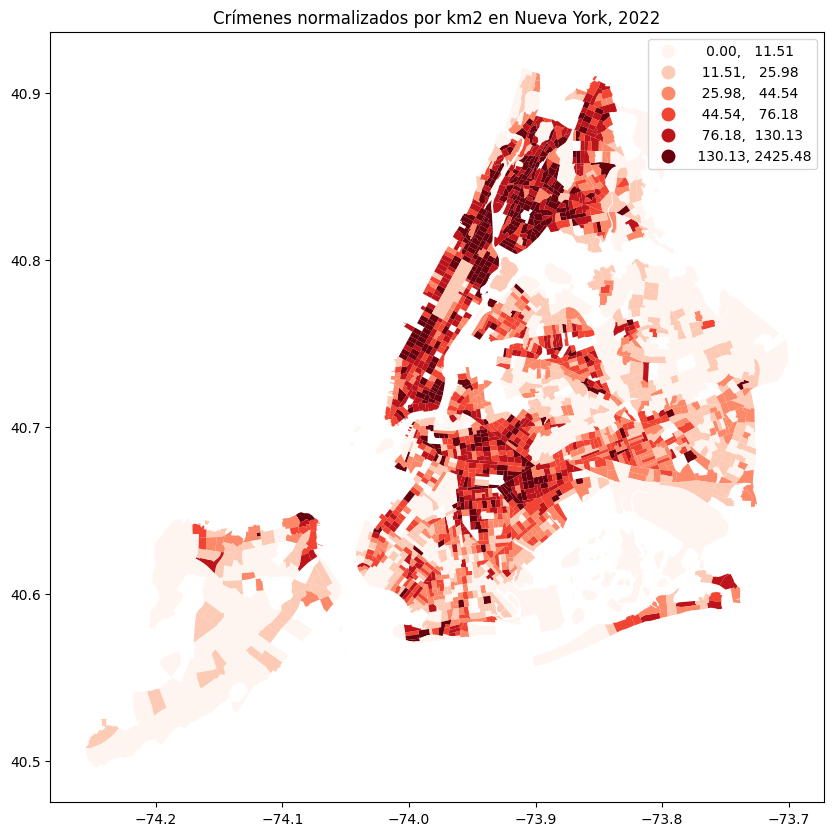

In [50]:
fig, ax = plt.subplots(1, figsize=(16,10))
squares.plot(ax=ax, column='crimes_prop', scheme='quantiles', k=6, cmap='Reds', figsize=(10,10), legend=True)
ax.set_title('Crímenes normalizados por km2 en Nueva York, 2022')

### 4. Discretización de raster de temperatura

In [18]:
# clip_mean_ST.select('ST_B10').getInfo()['properties']['system:footprint']['coordinates'][0][:-1]

#### No correr siguiente código, se importará el dataframe que se generó

In [ ]:
'''
init = time()
squares['geometry_geojson'] = squares['geometry'].apply(lambda x: x.__geo_interface__)

mean_temperatures = []

for index, row in squares.iterrows():
    # Get the geometry of the row
    geometry = row['geometry_geojson']
    clipped_image = clip_mean_ST.clip(geometry)
    
    mean_temperature = clipped_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry(geometry),
        scale=30
    ).get('ST_B10')
    
    mean_temperatures.append(mean_temperature.getInfo())
    if index%20==0:
        timer = time()
        delta = timer - init
        init = timer
        print(f'iteración {index}: {round(100*index/2034, 3)}% | Exec time: {delta}')

squares['mean_temperature'] = mean_temperatures
'''

Este código demora 35 min en correr, por lo que guardamos el dataframe y lo cargamos.

In [ ]:
# squares.to_file('squares_temperature.shp', driver="ESRI Shapefile")

In [19]:
squares = gpd.read_file('cuadras_temperatura/squares_temperature.shp')
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,Shape_Area,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry
192,151,2,Bronx,015100,2015100,None,Morrisania,BX0301,BX03,BX03 Morrisania-Crotona Park East (CD 3 Approx...,...,2.253624e+06,35,5458,2833,0.519055,0.209368,167.169427,"{""type"": ""Polygon"", ""coordinates"": [[[-73.8969...",42.253923,"POLYGON ((-73.89697 40.83434, -73.89679 40.834..."




Creamos una nueva fila en el geodataframe para definir las heat islands pero dividido por manzanas luego graficamos la temperatura promedio por manzana junto a las islas de calor en la ciudad

In [20]:
def is_heat_island(mean_temp):
    return 1 if mean_temp > 45 else 0

In [21]:
squares['heat_island'] = squares.apply(lambda x: is_heat_island(x.mean_tempe), axis=1)

Text(153.97222222222223, 0.5, 'Latitud')

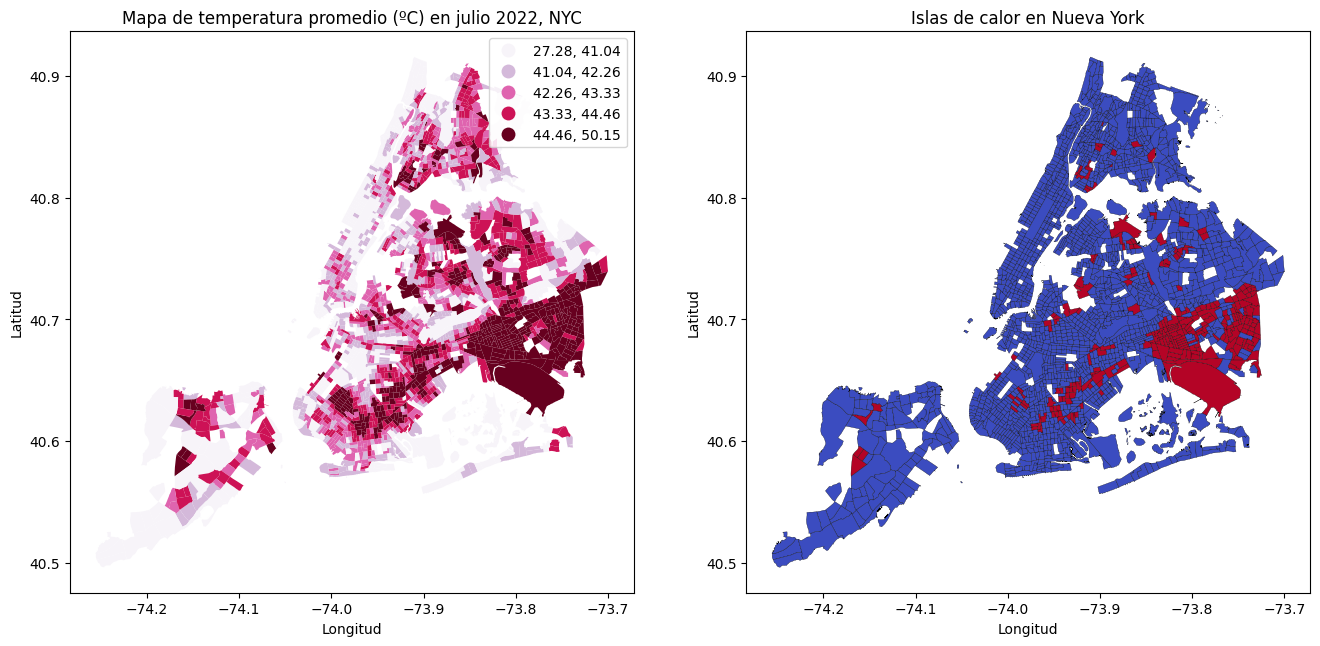

In [22]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[1], column='heat_island', categorical=True, cmap='coolwarm', linewidth=0.2, edgecolor='k', legend=False)
axes[1].set_title('Islas de calor en Nueva York')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

squares.plot(ax=axes[0], column='mean_tempe', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Mapa de temperatura promedio (ºC) en julio 2022, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

### 5. Análisis de autocorrelación espacial

Graficamos la temperatura de cada cuadra

Para calcular el lag espacial, normalizamos la variable mean_tempe (temperatura media de cada manzana)

In [24]:
mean = squares.crimes_pro.mean()
sd = squares.crimes_pro.std()
squares['crimes_prop_std'] = (squares['crimes_pro'] - mean)/sd
squares['index'] = squares.index

In [25]:
w = weights.Queen.from_dataframe(squares, ids='index')

/Users/terriblepollo/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 0, 147, 1174.
  warnings.warn(message)


In [26]:
squares['crimes_prop_lag'] = weights.spatial_lag.lag_spatial(w, squares['crimes_prop_std'])

<Axes: title={'center': 'Crímenes de género, año 2022 (normalizado), NYC'}>

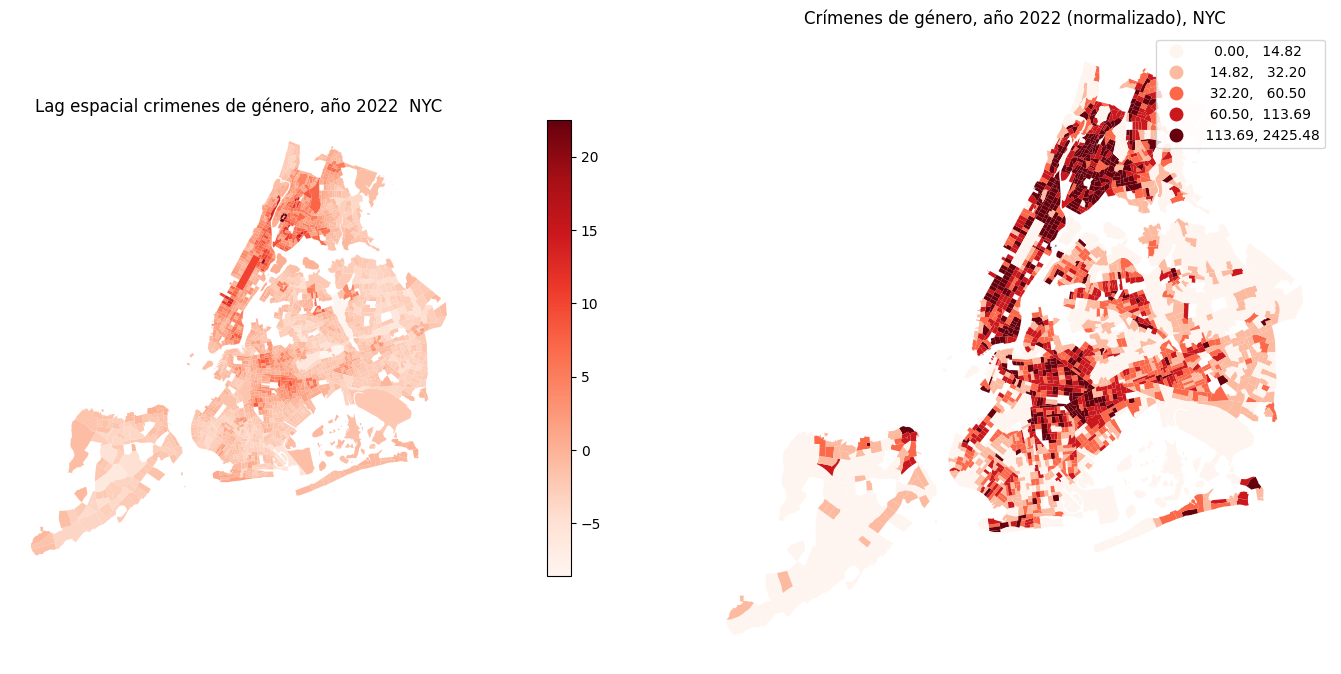

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
axes[0].set_axis_off()
axes[0].set_title('Lag espacial crimenes de género, año 2022  NYC')
squares.plot(ax=axes[0], column='crimes_prop_lag', cmap='Reds', linewidth=0.4,legend=False)
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes("right", size="4%", pad="1%")
plt.colorbar(axes[0].collections[0],cax=cax)

axes[1].set_axis_off()
axes[1].set_title('Crímenes de género, año 2022 (normalizado), NYC')
squares.plot(ax=axes[1], column='crimes_pro', scheme='quantiles', k=5, cmap='Reds',legend=True)


#### a. Moran Global para crímenes

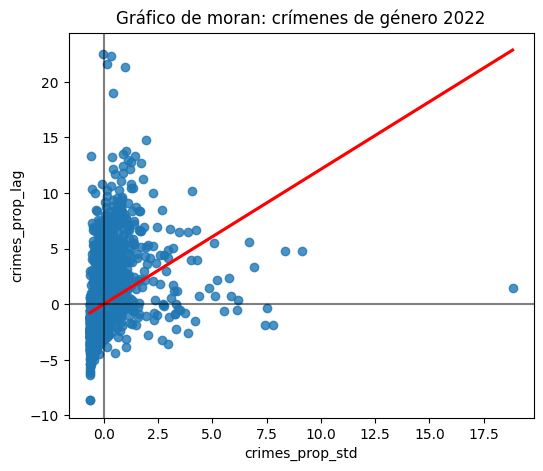

In [92]:
f, ax2 = plt.subplots(1, figsize=(6, 5))
sns.regplot(ax=ax2,
    x="crimes_prop_std",
    y="crimes_prop_lag",
    ci=None,
    data=squares,
    line_kws={"color": "r"},
)
ax2.axvline(0, c="k", alpha=0.5)
ax2.axhline(0, c="k", alpha=0.5)
ax2.set_title("Gráfico de moran: crímenes de género 2022")
plt.show()

In [93]:
w.transform = "R"
moran_crime = esda.moran.Moran(squares["crimes_pro"], w)
print(f'crimenes de genero -> Moran index: {moran_crime.I} | p-value: {moran_crime.p_sim}')

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 1174, ' is an island (no neighbors)')
crimenes de genero -> Moran index: 0.2086382527931002 | p-value: 0.001


Dado el alto valor del indice de Moran, y bajo valor p, hay una alta correlación global de los datos. (COMPLETAR)

#### b. Moran local para temperatura y crímenes

In [27]:
x_crime=squares['crimes_prop_std']
y_crime=squares['crimes_prop_lag']
lisa = esda.moran.Moran_Local(x_crime, w)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 1174, ' is an island (no neighbors)')


/Users/terriblepollo/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Slope: 1.213218692242464
HH
LL
LH
HL


Text(0.5, 0.98, 'LISA para crímenes de género')

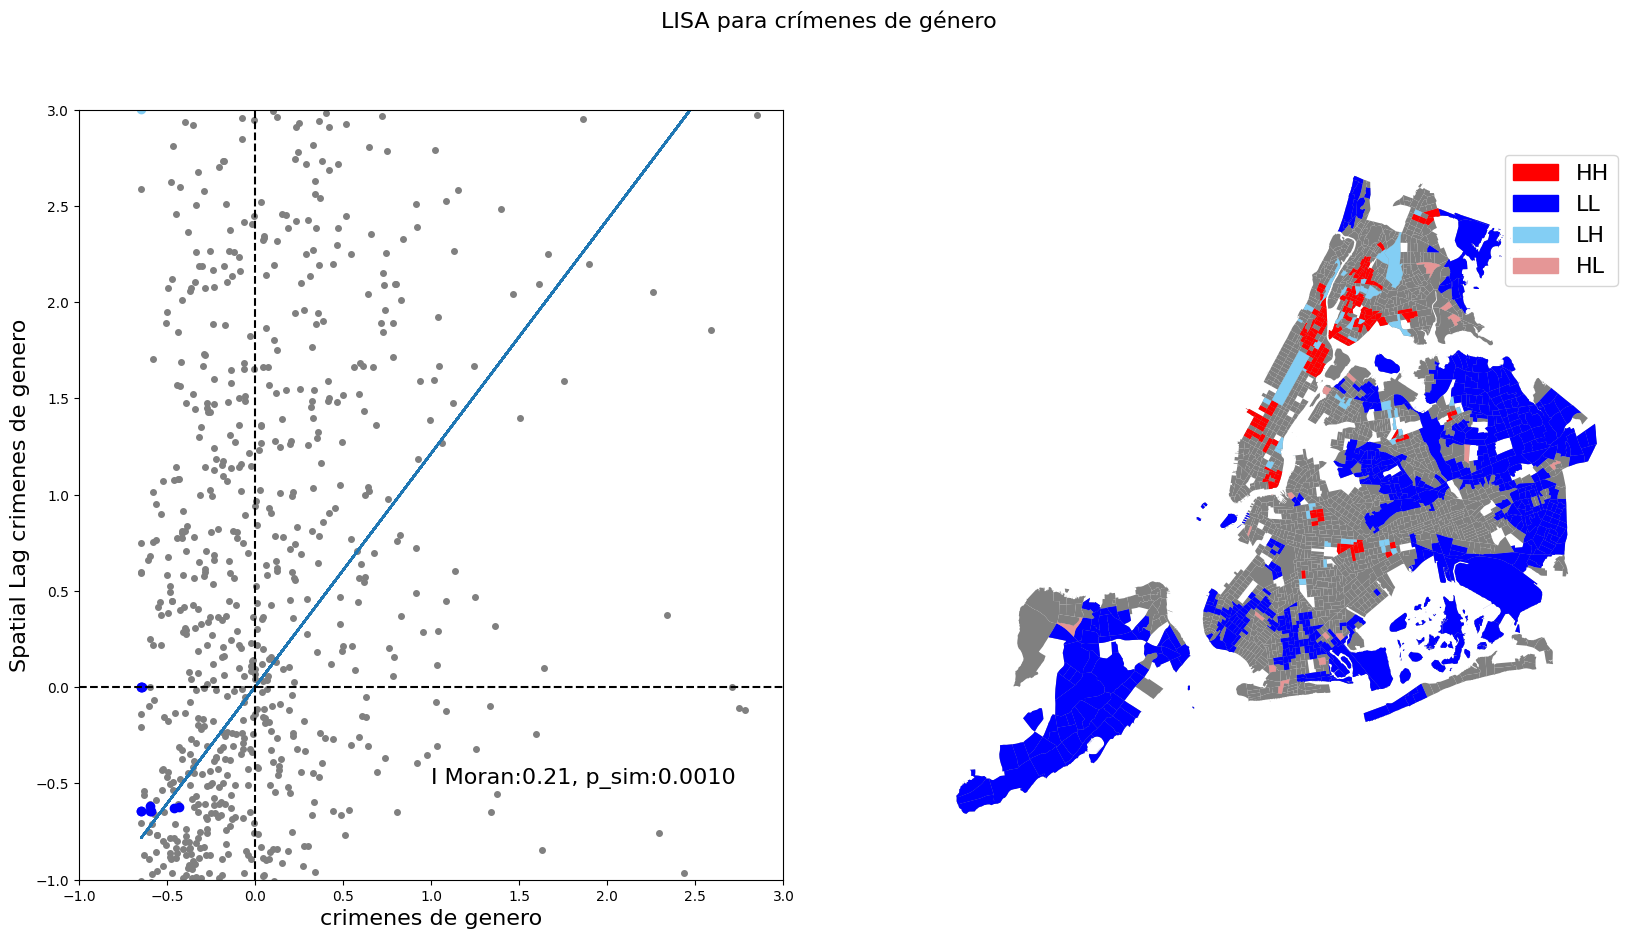

In [32]:
squares['quadrant_crime'] = lisa.q
squares['significant_crime'] = lisa.p_sim < 0.05

quads={1:'HH',2:'LH',3:'LL',4:'HL'}
palette = {'LL': 'blue','HH':'red','LH':'#83cef4','HL':'#e59696'}
squares['quad_class'] = [quads[x] for x in squares['quadrant_crime']]

squares['quad_class'] = [quads[x] for x in squares['quadrant_crime']]

HHm=(squares['significant_crime']) & (squares['quadrant_crime']==1) 
LLm=(squares['significant_crime']) & (squares['quadrant_crime']==3) 
HLm=(squares['significant_crime']) & (squares['quadrant_crime']==4) 
LHm=(squares['significant_crime']) & (squares['quadrant_crime']==2)

f,(ax,ax2) = plt.subplots(1,2, figsize=(20,10))

m,b= np.polyfit(x_crime, y_crime, 1)
print('Slope:',m)
ax.plot(x_crime,y_crime,'o',color='gray',markersize=4)

ax.plot(x_crime[HHm],y_crime[HHm],'o',color='r',markersize=6)
ax.plot(x_crime[LLm],y_crime[LLm],'o',color='b',markersize=6)
ax.plot(x_crime[LHm],y_crime[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x_crime[HLm],y_crime[HLm],'o',color='#e59696',markersize=6)

ax.plot(x_crime,m*x_crime+b,ls='--')
ax.set_xlabel('crimenes de genero',fontsize=16)
ax.set_ylabel('Spatial Lag crimenes de genero' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

mi = esda.moran.Moran(x_crime, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

sig=squares[squares['significant_crime']]
squares.plot(color='gray',ax=ax2)

datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}
handles=[]

for ctype in datsig.keys():
    print(ctype)
    data=squares[datsig[ctype]]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para crímenes de género', size=16)

El análisis nos muestra las zonas HH, HL, LH y LL. Es interesante notar que central park esta catalogado como LH, es decir, tiene baja criminalidad pero está rodeada por zonas de alta criminalidad. Esto seguramente se deba a la mayor presencia policial por ser una zona tan turística.

### 6. Conclusiones

Vemos como se comportan los crimenes a lo largo del año

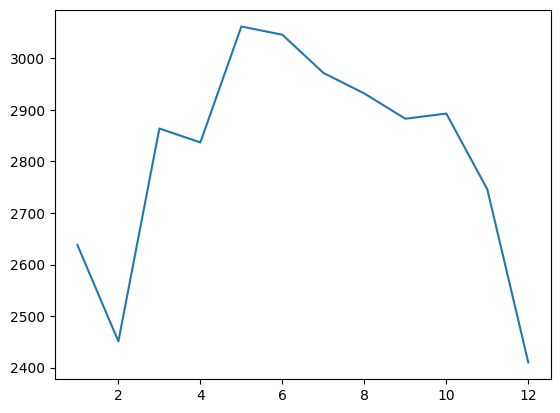

In [98]:
month_each_crime = [month for month in list(big_crimes["month"])]
crimes_by_month  = [month_each_crime.count(month) for month in range(1, 13)]
plt.plot(range(1, 13), crimes_by_month)

Obtenemos que, en general y sin considerar la relación con el lugar donde ocurren, que los casos de violencia de género sí aumenta en los meses más calurosos, mostrando un peak de mayo a julio. Esto no permite afirmar que haya una causalidad, pues la violencia es en sí un fenómeno multifactorial, pero nos incentiva a seguir investigando alguna posible correlación.

Graficamos ahora los crimenes por km $^2$ y las islas de calor lado a lado

In [99]:
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,geometry,heat_island,crimes_prop_std,index,crimes_prop_lag,quadrant,significant,quad_class,quadrant_crime,significant_crime
1267,160,3,Brooklyn,016000,3016000,None,Bay Ridge,BK1001,BK10,BK10 Bay Ridge-Dyker Heights (CD 10 Approximat...,...,"POLYGON ((-74.02621 40.62149, -74.02536 40.620...",0,-0.241203,1267,-3.637276,3,True,LL,3,True


Text(830.3358585858584, 0.5, 'Latitud')

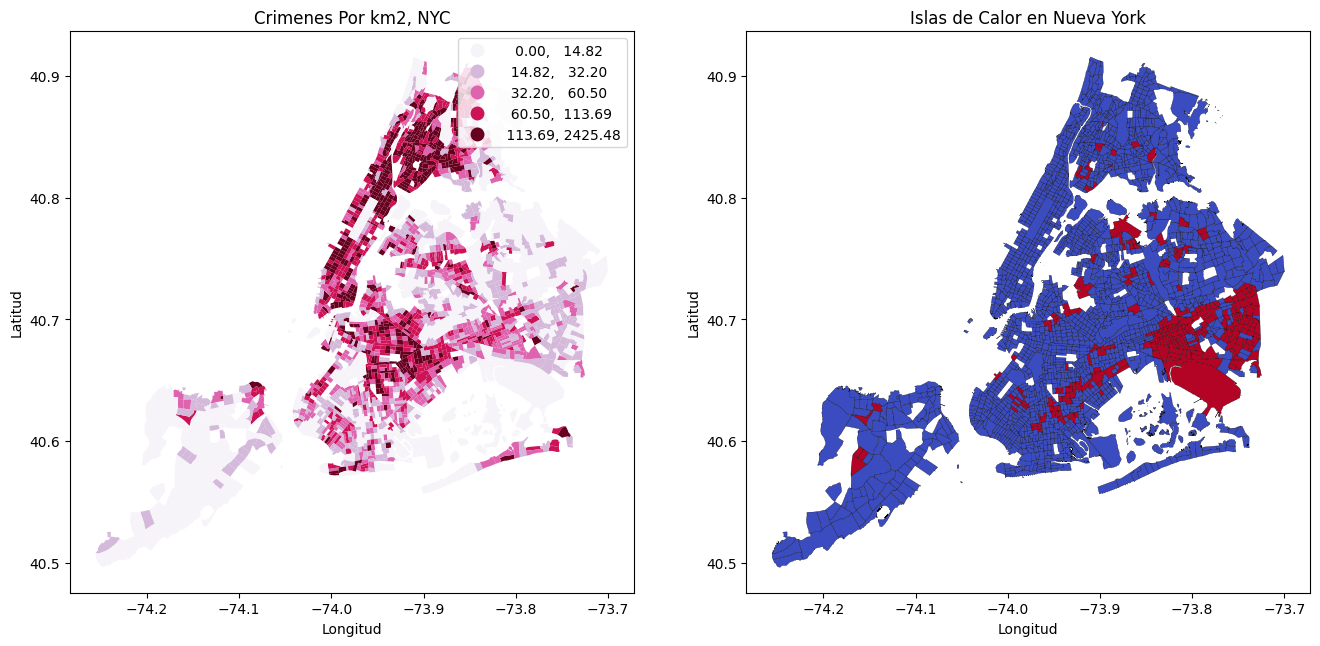

In [100]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[0], column='crimes_pro', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Crimenes Por km2, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

squares.plot(ax=axes[1], column='heat_island', categorical=True, cmap='coolwarm', linewidth=0.2, edgecolor='k', legend=False)
axes[1].set_title('Islas de Calor en Nueva York')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

Repetimos el proceso normalizando ambas variables, dejandolas acotadas entre 0 y 1

In [33]:
min_temp = min(list(squares["mean_tempe"])); max_temp = max(list(squares["mean_tempe"]))
min_crim = min(list(squares["crimes_pro"])); max_crim = max(list(squares["crimes_pro"]))
squares["temp_norm"] = squares.apply(lambda x : (x.mean_tempe - min_temp)/(max_temp - min_temp), axis=1)
squares["crim_norm"] = squares.apply(lambda x : (x.crimes_pro - min_crim)/(max_crim - min_crim), axis=1)

Text(830.3358585858584, 0.5, 'Latitud')

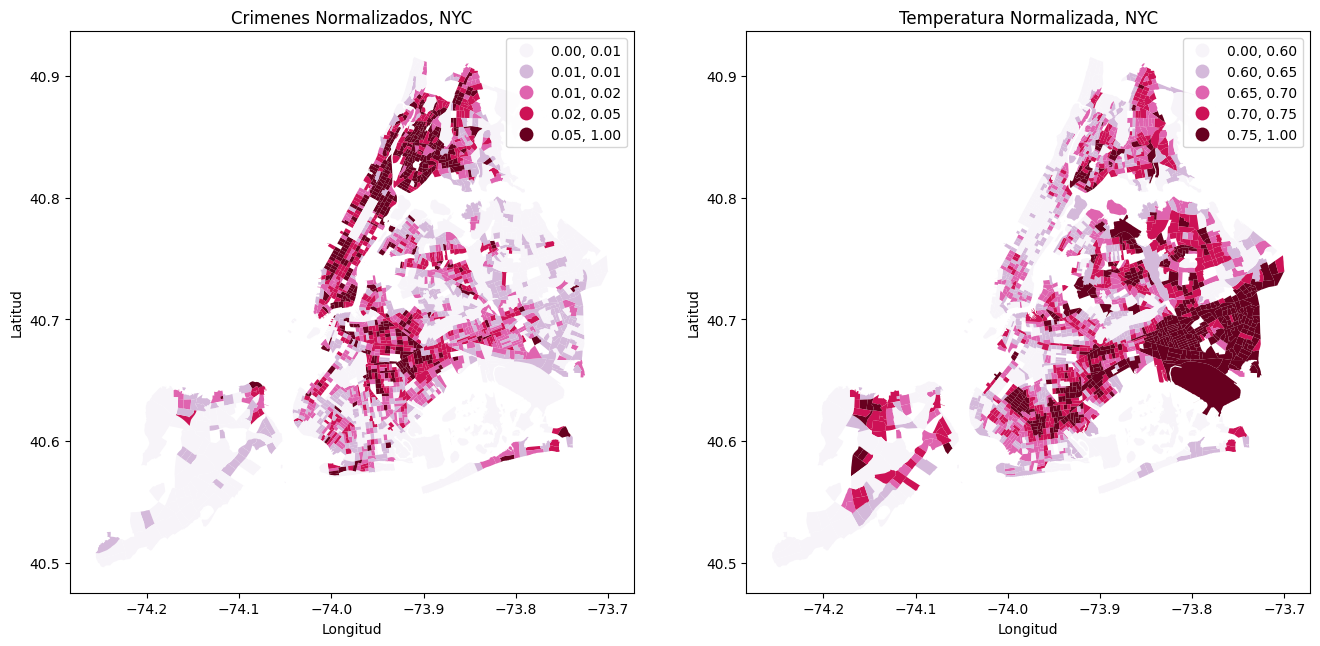

In [102]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[0], column='crim_norm', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Crimenes Normalizados, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

squares.plot(ax=axes[1], column='temp_norm', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[1].set_title('Temperatura Normalizada, NYC')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

In [34]:
squares['crim_norm'].corr(squares['temp_norm'])

-0.01829255390884753

In [35]:
squares['crim_norm'].corr(squares['heat_island'])

-0.0920282961591329

Se concluye que no hay correlación entre ambas variables, al obtener un valor pequeño para la correlación, vemos que no existe relación directa (alta temperatura, altos crímenes) ni inversa (baja temperatura, altos crímenes).

Ocurre exactamente lo mismo entre crímenes e islas de calor.

Sin embargo, como se indicó con anterioridad, no descartamos la posible existencia de una relació entre las variables, pues es posible que no se haya encontrado por otros factores. Creemos que quizá si se definen las islas de calor mediante segmentación u otros métodos, es posible que se alteren los resultados.